# C-VAE for MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Hyper-parameters 
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
N_EPOCH = 50


In [ ]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=original_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=original_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
class CVAE(nn.Module):
    def __init__(self, x_dim, z_dim, c_dim):
        super(CVAE, self).__init__()
        
        # Encoder Code
        self.fc1 = nn.Linear(x_dim + c_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, z_dim)
        self.fc32 = nn.Linear(256, z_dim)
        # Decoder Code
        self.fc4 = nn.Linear(z_dim + c_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, x_dim)
    def encoder(self, x, c):
        concat_input = torch.cat([x, c], 1)
        h = F.relu(self.fc1(concat_input))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)
    
    def decoder(self, z, c):
        concat_input = torch.cat([z, c], 1)
        h = F.relu(self.fc4(concat_input))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add(mu)    
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

In [ ]:
# Create Model
cond_dim = train_loader.dataset.train_labels.unique().size(0)
latent_dim = 32
cvae = CVAE(x_dim=784, z_dim=latent_dim, c_dim=cond_dim)

# Device setting
cvae = cvae.to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
#  Model
cvae

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=32, bias=True)
  (fc32): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=42, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return 1 * kl_loss + 1 * recon_loss #You can change constants

In [ ]:
def idx2onehot(idx, n=10):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

# Train
for epoch in range(1, N_EPOCH + 1):
    cvae.train()
    train_loss = 0
    for (data, cond) in train_loader:
        data = data.to(device)
        
        cond = idx2onehot(cond.view(-1, 1)) # create one-hot condition
        cond = cond.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}/{}\t Average loss: {:.4f}'.format(epoch, N_EPOCH, train_loss / len(train_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/50	 Average loss: 150.2058
Epoch: 2/50	 Average loss: 115.5357
Epoch: 3/50	 Average loss: 108.9369
Epoch: 4/50	 Average loss: 105.4312
Epoch: 5/50	 Average loss: 103.2797
Epoch: 6/50	 Average loss: 101.7030
Epoch: 7/50	 Average loss: 100.4024
Epoch: 8/50	 Average loss: 99.4059
Epoch: 9/50	 Average loss: 98.7325
Epoch: 10/50	 Average loss: 98.1676
Epoch: 11/50	 Average loss: 97.5785
Epoch: 12/50	 Average loss: 97.1423
Epoch: 13/50	 Average loss: 96.7912
Epoch: 14/50	 Average loss: 96.4375
Epoch: 15/50	 Average loss: 96.1167
Epoch: 16/50	 Average loss: 95.8599
Epoch: 17/50	 Average loss: 95.6684
Epoch: 18/50	 Average loss: 95.4050
Epoch: 19/50	 Average loss: 95.2135
Epoch: 20/50	 Average loss: 95.0327
Epoch: 21/50	 Average loss: 94.8606
Epoch: 22/50	 Average loss: 94.7093
Epoch: 23/50	 Average loss: 94.6000
Epoch: 24/50	 Average loss: 94.4197
Epoch: 25/50	 Average loss: 94.3404
Epoch: 26/50	 Average loss: 94.1620
Epoch: 27/50	 Average loss: 94.0618
Epoch: 28/50	 Average loss: 93

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


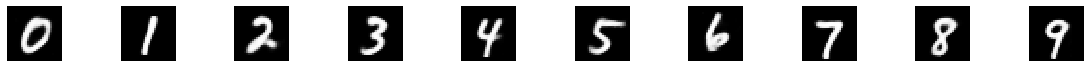

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np
digit_size = 28
z_sample = np.random.rand(1, latent_dim).astype(np.float32) # random 
plt.figure(figsize=(20, 1))

for i in range(10):
    c = np.zeros((1, cond_dim)).astype(np.float32)
    c[0][i] = 1
    
    cvae.eval()
    with torch.no_grad():
        img = cvae.decoder(torch.tensor(z_sample).to(device), torch.tensor(c).to(device)).to('cpu')
        # reshape (if needed)
        img = img.view([28,28])

    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(img, cmap='Greys_r',)
plt.show()


# UMAP


In [ ]:
# Create latent space and labels for UMAP
cvae.eval()
latent = None
labels = None
with torch.no_grad():
    for data, cond in test_loader:
        data = data.to(device)
        data = data.view(-1, 784)
        
        if labels is None:
            labels = cond
        else:
            # concatenate labels and cond
            labels = np.concatenate((labels,cond))
            
        cond = idx2onehot(cond.view(-1, 1)) # create one-hot condition
        cond = cond.to(device)
        batch_latent, _ = cvae.encoder(data, cond)
        if latent is None:
            latent = batch_latent.to('cpu').numpy()
        else:
            # concatenate latent and batch_latent
            latent = np.vstack((latent, batch_latent.to('cpu').numpy()))


In [ ]:
!pip install scanpy

     |████████████████████████████████| 6.5MB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 13.0MB 44.2MB/s 
  Using cached https://files.pythonhosted.org/packages/1d/70/97966deebaeeda0b81d3cd63ba9f8ec929b838871ed17476de9d8159db3e/setuptools_scm-3.3.3-py2.py3-none-any.whl
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for scanpy: filename=scanpy-1.4.5.post1-cp36-none-any.whl size=264599 sha256=7a91818d975763e5ed6455b1626f2523c47248494ba84b4da5fe2bc4557bb20f
  Stored in directory: /root/.cache/pip/wheels/f8/d9/2f/a030dd084850f7e21999b719f4ea600bd9d374fe07fffc1e82
Successfully built scanpy
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.0.

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

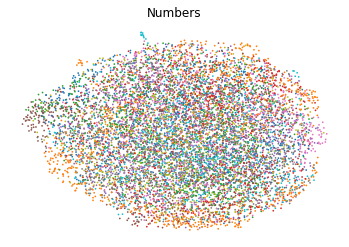

In [ ]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent,
                        obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)